In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.engine.topology import Layer
from keras.layers import Input, Dropout, Dense
from keras.layers import Embedding, GRU, LSTM, Bidirectional, TimeDistributed
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, LambdaCallback, TensorBoard
from keras.optimizers import SGD, Adam

%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(3)
from tensorflow import set_random_seed
set_random_seed(24)

In [3]:
with open('data_final/reliable_final.pkl', 'rb') as infile:
    reliable = pickle.load(infile)

In [4]:
with open('data_final/unreliable_final.pkl', 'rb') as infile:
    unreliable = pickle.load(infile)

In [5]:
reliable['label'] = 0
unreliable['label'] = 1
data = reliable.append(unreliable)

In [6]:
max_words = 30  # max num words processed for each sentence
max_sentences = 30  # max num sentences processed for each article 
max_vocab = 50000
embedding_dim = 100  # size of pretrained word vectors
attention_dim = 128  # num units in attention layer
GRU_dim = 64  # num units in GRU layer, but it is bidirectional so outputs double this number
batch_size = 128
test_size = 0.2

vector_dir = './embeddings'
vector_file = 'glove.6B.100d.txt'
model_dir = './model_output/glove_100'
tb_logs = './tb_logs/glove_100'

In [7]:
# Split data into train and test sets. Test set will not be used in any way until model is trained.

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

x_train, x_test, y_train, y_test = train_test_split(data['content'], data['label'], test_size=test_size,
                                                    random_state=77, stratify=data['label'])

y_train, y_test = np.asarray(y_train), np.asarray(y_test)

In [8]:
# Build vocab word index (dict) from training articles

from collections import Counter 
words = Counter()
for article in x_train:
    for sentence in article:
        sentence = [word.lower() for word in sentence]
        words.update(sentence)
    
with open('data_final/words.pkl', 'wb') as outfile:
    pickle.dump(words, outfile)

An embedding matrix must be constructed so that the embedding layer can look up and use the vector associated with each word. As an intermediary step, the words are first replaced with their respective indices in the word index. The embedding matrix uses these same indices for the lookup.

Only the most common *n* words will be used from the word index. By pre-populating the data and embedding matrices with zeros, any words outside the *n*-word vocabulary or not found in the set of embedding vectors will be represented by a zero or vector of zeros. The GRU and attention layers support masking, which avoids having to process vectors of all zeros.

Trial runs to ensure that the network is working properly and to determine learning rate bounds (to be used with a cyclic learning rate approach) will be conducted with a small subset of the training data comprising 10,000 articles.

In [9]:
for ix, (word, _) in enumerate(words.most_common(max_vocab)):
    word_index[word] = ix + 1 # The zero index is reserved for masking out-of-vocab words

In [10]:
def create_data_matrix(data, max_sentences=max_sentences, max_words=max_words, max_vocab=max_vocab,
                      word_index=word_index):
    data_matrix = np.zeros((len(data), max_sentences, max_words), dtype='int32')
    for i, article in enumerate(data):
        for j, sentence in enumerate(article):
            if j == max_sentences:
                break
            k = 0
            for word in sentence:
                if k == max_words:
                    break
                ix = word_index.get(word.lower())
                if ix is not None and ix < max_vocab:
                    data_matrix[i, j, k] = ix
                k = k + 1
    return data_matrix  

In [11]:
sample_data = reliable.sample(5000).append(unreliable.sample(5000))

In [12]:
sample_x_train, sample_x_test, sample_y_train, sample_y_test = train_test_split(sample_data['content'],
                                                    sample_data['label'], test_size=test_size,
                                                    random_state=77, stratify=sample_data['label'])

In [13]:
sample_train_matrix = create_data_matrix(sample_x_train)
sample_test_matrix = create_data_matrix(sample_x_test)

sample_y_train = np.asarray(to_categorical(sample_y_train))
sample_y_test = np.asarray(to_categorical(sample_y_test))

sample_data = shuffle(sample_data)  # For finding the learning rate, no validation set needed
sample_targets = np.asarray(to_categorical(sample_data['label']))

In [14]:
def store_embeddings(vector_dir=vector_dir, vector_file=vector_file):
    embeddings = {}
    with open(os.path.join(vector_dir, vector_file)) as vectors:
        for line in vectors:
            values = line.split()
            word = values[0]
            weights = np.asarray(values[1:], dtype='float32')
            embeddings[word] = weights
    return embeddings
            
embeddings = store_embeddings()

In [15]:
def create_embedding_matrix(max_vocab=max_vocab, embeddings=embeddings, word_index=word_index,
                            embedding_dim=embedding_dim):
    embedding_matrix = np.zeros((max_vocab + 1, embedding_dim)) # max_vocab + 1 to account for 0 as masking index
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will remain all zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
            
embedding_matrix = create_embedding_matrix()

In [16]:
# Construct attention layer

from tensorflow import matmul
class HierarchicalAttentionNetwork(Layer):
    ''''''
    def __init__(self, attention_dim):
        self.init_weights = initializers.get('glorot_normal')
        self.init_bias = initializers.get('zeros')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super().__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init_weights((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init_bias((self.attention_dim,)))
        self.u = K.variable(self.init_weights((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super().build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):        
        #uit = K.tile(K.expand_dims(self.W, axis=0), (K.shape(x)[0], 1, 1))
        #uit = matmul(x, uit)
        #uit = K.tanh(K.bias_add(uit, self.b))
        #ait = K.dot(uit, self.u)
        #ait = K.squeeze(ait, -1)

        #ait = K.exp(ait)
        
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))
        
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [71]:
def build_model(attention_dim=attention_dim, GRU_dim=GRU_dim, drop=False, drop_pct=None,
                embedding_matrix=embedding_matrix, embedding_dim=embedding_dim, word_index=word_index):
    
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                                input_length=max_words, trainable=False, mask_zero=True)

    #  Layers for processing words in each sentence with attention; output is encoded sentence vector 
    sentence_input = Input(shape=(max_words,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)
    lstm_word = Bidirectional(GRU(GRU_dim, return_sequences=True))(embedded_sequences)
    attn_word = HierarchicalAttentionNetwork(attention_dim)(lstm_word)
    sentence_encoder = Model(sentence_input, attn_word)
    
    #  Layers for processing sentences in each article with attention; output is prediction
    article_input = Input(shape=(max_sentences, max_words), dtype='int32')
    article_encoder = TimeDistributed(sentence_encoder)(article_input)
    lstm_sentence = Bidirectional(GRU(GRU_dim, return_sequences=True))(article_encoder)
    attn_sentence = HierarchicalAttentionNetwork(attention_dim)(lstm_sentence)
    #  The Adam optimizer also will be tried and can take a dropout layer
    if drop:
        drop_sentence = Dropout(drop_pct)(attn_sentence)
        preds = Dense(2, activation='softmax')(drop_sentence)
    else:
        preds = Dense(2, activation='softmax')(attn_sentence)
    
    return Model(article_input, preds)

In [18]:
# create checkpoints to save information from each training epoch

model_checkpoint = ModelCheckpoint(filepath=model_dir+'weights.{epoch:02d}.hdf5')
tb_checkpoint = TensorBoard(log_dir=tb_logs, histogram_freq=1, batch_size=128, write_graph=False, write_grads=True,
                            write_images=True)

if not os.path.exists(model_dir):
        os.makedirs(model_dir, exist_ok=True)
        
if not os.path.exists(tb_logs):
        os.makedirs(tb_logs, exist_ok=True)

The network will be trained using a cyclic learning rate as proposed in the 2017 paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf). This enables quicker convergence by helping to avoid getting stuck in local minima or saddle points on the loss surface. A [reference implementation](https://github.com/bckenstler/CLR) is available on Github, and a three-post walk-through on [pyimagesearch](https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/) includes code in more detail. The approach has two steps. The first uses a learning rate vs. loss graph to determine the minimum and maximum learning rates. A Keras callback then varies the learning rate back and forth between these two values during training.

In [19]:
start_lr = 1e-8
K.clear_session()
try:
    del model
except NameError:
    pass
model = build_model()
opt = SGD(lr=start_lr, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [20]:
from cyclic.rate_finder import LearningRateFinder
find_lr = LearningRateFinder(model)

find_lr_data = create_data_matrix(sample_data['content'])

In [21]:
find_lr.find(find_lr_data, sample_targets, start_lr=1e-8, end_lr=1., epochs=3, batch_size=batch_size)

Epoch 1/3
10000/10000 [==============================] - 223s 22ms/step - loss: 0.6913 - acc: 0.5008
Epoch 2/3
10000/10000 [==============================] - 221s 22ms/step - loss: 0.6900 - acc: 0.5075
Epoch 3/3
10000/10000 [==============================] - 225s 22ms/step - loss: 0.6781 - acc: 0.5979


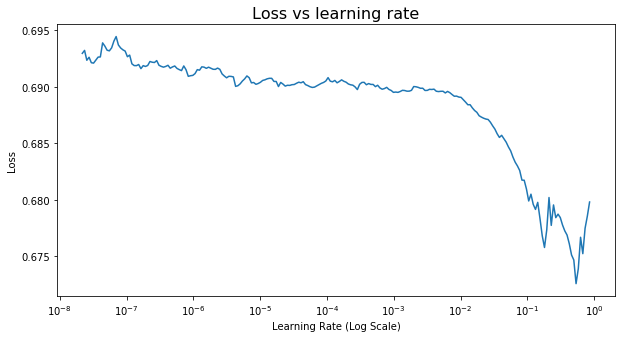

In [22]:
find_lr.plot_loss()

The plot shows that effective learning (steady drop in loss) begins around $10^{-2.5}$, and
learning becomes erratic and the loss quickly explodes above $10^{-1}$. So the learning rates will cycle between these two values.

In [24]:
from keras.callbacks import Callback
from cyclic.rate_cycler import CyclicLR

Using the min/max learning rates determined above, do test runs with the sample_train and sample_test data to determine the best choices for number of embedding, attention and GRU dimensions. Start with the smallest and see if increasing these dimensions results in significant performance improvement.

In [25]:
clr = CyclicLR(epochs=4, num_samples=8000, batch_size=batch_size)

In [26]:
K.clear_session()
try:
    del model
except NameError:
    pass
model = build_model()
opt = SGD(momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [27]:
model.fit(sample_train_matrix, sample_y_train, validation_data=(sample_test_matrix, sample_y_test),
          batch_size=batch_size, epochs=4, callbacks=[clr])

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 191s 24ms/step - loss: 0.6837 - acc: 0.5656 - val_loss: 0.6355 - val_acc: 0.6510
Epoch 2/4
8000/8000 [==============================] - 189s 24ms/step - loss: 0.6016 - acc: 0.6859 - val_loss: 0.5909 - val_acc: 0.6870
Epoch 3/4
8000/8000 [==============================] - 203s 25ms/step - loss: 0.5816 - acc: 0.6975 - val_loss: 0.5718 - val_acc: 0.7040
Epoch 4/4
8000/8000 [==============================] - 199s 25ms/step - loss: 0.5604 - acc: 0.7103 - val_loss: 0.5589 - val_acc: 0.7135


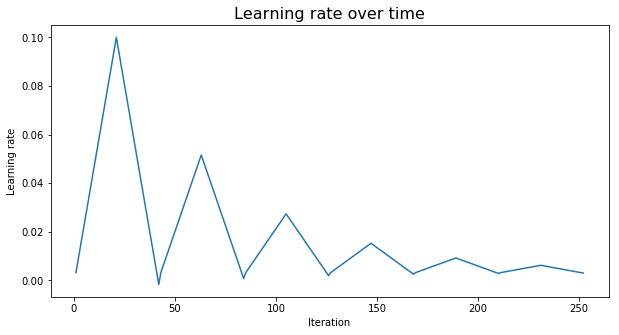

In [28]:
clr.plot_lr()

In [51]:
K.clear_session()
try:
    del model
except NameError:
    pass
model = build_model()
opt = SGD(momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [52]:
model.fit(sample_train_matrix, sample_y_train, validation_data=(sample_test_matrix, sample_y_test),
          batch_size=batch_size, epochs=4, callbacks=[clr])

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 188s 23ms/step - loss: 0.6941 - acc: 0.5106 - val_loss: 0.6834 - val_acc: 0.6240
Epoch 2/4
8000/8000 [==============================] - 189s 24ms/step - loss: 0.6768 - acc: 0.6044 - val_loss: 0.6714 - val_acc: 0.6165
Epoch 3/4
8000/8000 [==============================] - 189s 24ms/step - loss: 0.6636 - acc: 0.6335 - val_loss: 0.6592 - val_acc: 0.6340
Epoch 4/4
8000/8000 [==============================] - 187s 23ms/step - loss: 0.6506 - acc: 0.6482 - val_loss: 0.6478 - val_acc: 0.6425


Nesterov momentum did not improve performance, but the algorithms should also be tried without the cyclic learning rate, after which the Adam optimizer will be tried. A first experiment with Adam showed excessive overfitting, so it will be tried with a dropout layer.

In [57]:
def run_trial(attention_dim=attention_dim, GRU_dim=GRU_dim, embedding_matrix=embedding_matrix, embedding_dim=embedding_dim,
              momentum=0.9, batch_size=batch_size, epochs=4, cyclic=False, nesterov=False, adam=False, drop_pct=0.5,
              X=sample_train_matrix, y=sample_y_train, X_val=sample_test_matrix, y_val=sample_y_test,
              word_index=word_index):
    K.clear_session()
    try:
        del model
    except NameError:
        pass
    
    
    if adam is True:
        opt = Adam()
        model = build_model(attention_dim=attention_dim, GRU_dim=GRU_dim, embedding_matrix=embedding_matrix,
                            embedding_dim=embedding_dim, word_index=word_index, drop=True, drop_pct=drop_pct)
    else:
        opt = SGD(momentum=momentum, nesterov=nesterov)
        model = build_model(attention_dim=attention_dim, GRU_dim=GRU_dim, embedding_matrix=embedding_matrix,
                            embedding_dim=embedding_dim, word_index=word_index)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    
    if cyclic is True:
        clr = CyclicLR(epochs=epochs, num_samples=8000, batch_size=batch_size)
        model.fit(X, y, validation_data=(sample_test_matrix, sample_y_test),
                  batch_size=batch_size, epochs=epochs, callbacks=[clr])
    else:
        model.fit(X, y, validation_data=(sample_test_matrix, sample_y_test),
                  batch_size=batch_size, epochs=epochs)

In [54]:
run_trial()  # SGD without cyclic learning rate or Nesterov momentum

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 209s 26ms/step - loss: 0.6744 - acc: 0.6034 - val_loss: 0.6553 - val_acc: 0.6390
Epoch 2/4
8000/8000 [==============================] - 199s 25ms/step - loss: 0.6350 - acc: 0.6561 - val_loss: 0.6158 - val_acc: 0.6665
Epoch 3/4
8000/8000 [==============================] - 240s 30ms/step - loss: 0.6053 - acc: 0.6683 - val_loss: 0.6136 - val_acc: 0.6545
Epoch 4/4
8000/8000 [==============================] - 227s 28ms/step - loss: 0.5793 - acc: 0.6953 - val_loss: 0.5728 - val_acc: 0.6995


In [55]:
run_trial(nesterov=True)  # SGD without cyclic learning rate but with Nesterov momentum

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 195s 24ms/step - loss: 0.6747 - acc: 0.6011 - val_loss: 0.6525 - val_acc: 0.6425
Epoch 2/4
8000/8000 [==============================] - 193s 24ms/step - loss: 0.6325 - acc: 0.6601 - val_loss: 0.6145 - val_acc: 0.6595
Epoch 3/4
8000/8000 [==============================] - 196s 25ms/step - loss: 0.5986 - acc: 0.6811 - val_loss: 0.5842 - val_acc: 0.6885
Epoch 4/4
8000/8000 [==============================] - 200s 25ms/step - loss: 0.5689 - acc: 0.7023 - val_loss: 0.5602 - val_acc: 0.7060


In [58]:
run_trial(adam=True)  # Adam optimizer with default 50% dropout in feed to prediction layer

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 197s 25ms/step - loss: 0.6312 - acc: 0.6339 - val_loss: 0.5431 - val_acc: 0.7115
Epoch 2/4
8000/8000 [==============================] - 199s 25ms/step - loss: 0.4933 - acc: 0.7470 - val_loss: 0.4639 - val_acc: 0.7680
Epoch 3/4
8000/8000 [==============================] - 197s 25ms/step - loss: 0.3787 - acc: 0.8251 - val_loss: 0.4583 - val_acc: 0.7820
Epoch 4/4
8000/8000 [==============================] - 197s 25ms/step - loss: 0.2369 - acc: 0.9065 - val_loss: 0.5508 - val_acc: 0.7685


The 50% dropout somewhat lessened the gap between the training and validation accuracy scores, both of which are significantly higher than with SGD optimization, but the model is still overfitting significantly. Even worse, the validation accuracy has decreased during the last epoch, while the training accuracy crossed 90%, leaving not much room for improvement. Reducing the GRU and/or attention dimensions could help.

In [59]:
run_trial(attention_dim=64, adam=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 186s 23ms/step - loss: 0.6109 - acc: 0.6647 - val_loss: 0.5296 - val_acc: 0.7095
Epoch 2/4
8000/8000 [==============================] - 181s 23ms/step - loss: 0.4789 - acc: 0.7552 - val_loss: 0.4712 - val_acc: 0.7540
Epoch 3/4
8000/8000 [==============================] - 182s 23ms/step - loss: 0.3768 - acc: 0.8227 - val_loss: 0.4484 - val_acc: 0.7855
Epoch 4/4
8000/8000 [==============================] - 183s 23ms/step - loss: 0.2381 - acc: 0.9029 - val_loss: 0.5182 - val_acc: 0.7780


In [60]:
run_trial(GRU_dim=32, attention_dim=64, adam=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 124s 15ms/step - loss: 0.6404 - acc: 0.6292 - val_loss: 0.5523 - val_acc: 0.7095
Epoch 2/4
8000/8000 [==============================] - 122s 15ms/step - loss: 0.4968 - acc: 0.7452 - val_loss: 0.4680 - val_acc: 0.7770
Epoch 3/4
8000/8000 [==============================] - 125s 16ms/step - loss: 0.3976 - acc: 0.8110 - val_loss: 0.4533 - val_acc: 0.7805
Epoch 4/4
8000/8000 [==============================] - 120s 15ms/step - loss: 0.2784 - acc: 0.8787 - val_loss: 0.4819 - val_acc: 0.7820


In [61]:
run_trial(GRU_dim=16, attention_dim=32, adam=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 84s 11ms/step - loss: 0.6440 - acc: 0.6301 - val_loss: 0.5658 - val_acc: 0.6990
Epoch 2/4
8000/8000 [==============================] - 79s 10ms/step - loss: 0.5186 - acc: 0.7398 - val_loss: 0.4917 - val_acc: 0.7430
Epoch 3/4
8000/8000 [==============================] - 80s 10ms/step - loss: 0.4256 - acc: 0.7995 - val_loss: 0.4441 - val_acc: 0.7850
Epoch 4/4
8000/8000 [==============================] - 80s 10ms/step - loss: 0.3329 - acc: 0.8544 - val_loss: 0.4536 - val_acc: 0.7805


In [62]:
run_trial(GRU_dim=16, attention_dim=16, adam=True, drop_pct=0.6)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 89s 11ms/step - loss: 0.6606 - acc: 0.5984 - val_loss: 0.5876 - val_acc: 0.6990
Epoch 2/4
8000/8000 [==============================] - 78s 10ms/step - loss: 0.5388 - acc: 0.7169 - val_loss: 0.5012 - val_acc: 0.7420
Epoch 3/4
8000/8000 [==============================] - 78s 10ms/step - loss: 0.4492 - acc: 0.7889 - val_loss: 0.4689 - val_acc: 0.7745
Epoch 4/4
8000/8000 [==============================] - 78s 10ms/step - loss: 0.3680 - acc: 0.8416 - val_loss: 0.4528 - val_acc: 0.7895


In [63]:
run_trial(GRU_dim=16, attention_dim=8, adam=True, drop_pct=0.6)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 88s 11ms/step - loss: 0.6550 - acc: 0.6134 - val_loss: 0.5926 - val_acc: 0.6915
Epoch 2/4
8000/8000 [==============================] - 77s 10ms/step - loss: 0.5363 - acc: 0.7304 - val_loss: 0.4896 - val_acc: 0.7595
Epoch 3/4
8000/8000 [==============================] - 78s 10ms/step - loss: 0.4495 - acc: 0.7899 - val_loss: 0.4495 - val_acc: 0.7850
Epoch 4/4
8000/8000 [==============================] - 78s 10ms/step - loss: 0.3563 - acc: 0.8468 - val_loss: 0.4369 - val_acc: 0.7995


In [64]:
run_trial(GRU_dim=8, attention_dim=8, adam=True, drop_pct=0.7)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 67s 8ms/step - loss: 0.6855 - acc: 0.5719 - val_loss: 0.6443 - val_acc: 0.6570
Epoch 2/4
8000/8000 [==============================] - 61s 8ms/step - loss: 0.6117 - acc: 0.6826 - val_loss: 0.5669 - val_acc: 0.7130
Epoch 3/4
8000/8000 [==============================] - 61s 8ms/step - loss: 0.5399 - acc: 0.7382 - val_loss: 0.4923 - val_acc: 0.7670
Epoch 4/4
8000/8000 [==============================] - 61s 8ms/step - loss: 0.4536 - acc: 0.7989 - val_loss: 0.4542 - val_acc: 0.7720


Even with the GRU and attention dimensions as low as 8 and the dropout up to 70%, it can be seen that the training accuracy races ahead of the validation accuracy by the fourth epoch. Running it on the full dataset of 600,000+ articles would only make matters worse, although it is possible that good results could be obtained with a very few training epochs. The best performing combination for more extensive training without overfitting was the first, SGD with cyclic learning and no Nesterov momentum.

In [65]:
run_trial(momentum=0.8, cyclic=True)  # Reduced momentum

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 195s 24ms/step - loss: 0.6699 - acc: 0.5884 - val_loss: 0.6608 - val_acc: 0.5935
Epoch 2/4
8000/8000 [==============================] - 192s 24ms/step - loss: 0.6228 - acc: 0.6604 - val_loss: 0.6132 - val_acc: 0.6600
Epoch 3/4
8000/8000 [==============================] - 190s 24ms/step - loss: 0.6025 - acc: 0.6808 - val_loss: 0.6037 - val_acc: 0.6715
Epoch 4/4
8000/8000 [==============================] - 191s 24ms/step - loss: 0.5902 - acc: 0.6915 - val_loss: 0.5891 - val_acc: 0.6835


Reducing momentum does not give any performance gain, so keep it at 0.9.

In [66]:
run_trial(GRU_dim=100, attention_dim=200, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 283s 35ms/step - loss: 0.6850 - acc: 0.5763 - val_loss: 0.6417 - val_acc: 0.6445
Epoch 2/4
8000/8000 [==============================] - 276s 34ms/step - loss: 0.6104 - acc: 0.6756 - val_loss: 0.5948 - val_acc: 0.6805
Epoch 3/4
8000/8000 [==============================] - 275s 34ms/step - loss: 0.5829 - acc: 0.7002 - val_loss: 0.5781 - val_acc: 0.7005
Epoch 4/4
8000/8000 [==============================] - 274s 34ms/step - loss: 0.5651 - acc: 0.7103 - val_loss: 0.5702 - val_acc: 0.7015


Increasing the attention and GRU dimensions does not improve performance. Can these be reduced?

In [67]:
run_trial(GRU_dim=50, attention_dim=100, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 197s 25ms/step - loss: 0.6471 - acc: 0.6111 - val_loss: 0.6089 - val_acc: 0.6670
Epoch 2/4
8000/8000 [==============================] - 189s 24ms/step - loss: 0.5971 - acc: 0.6784 - val_loss: 0.5754 - val_acc: 0.6975
Epoch 3/4
8000/8000 [==============================] - 169s 21ms/step - loss: 0.5650 - acc: 0.7051 - val_loss: 0.5583 - val_acc: 0.7065
Epoch 4/4
8000/8000 [==============================] - 171s 21ms/step - loss: 0.5526 - acc: 0.7124 - val_loss: 0.5504 - val_acc: 0.7110


In [68]:
run_trial(GRU_dim=64, attention_dim=32, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 194s 24ms/step - loss: 0.6616 - acc: 0.5896 - val_loss: 0.6152 - val_acc: 0.6575
Epoch 2/4
8000/8000 [==============================] - 218s 27ms/step - loss: 0.6379 - acc: 0.6452 - val_loss: 0.5842 - val_acc: 0.6955
Epoch 3/4
8000/8000 [==============================] - 205s 26ms/step - loss: 0.5712 - acc: 0.7055 - val_loss: 0.5678 - val_acc: 0.6995
Epoch 4/4
8000/8000 [==============================] - 192s 24ms/step - loss: 0.5539 - acc: 0.7175 - val_loss: 0.5492 - val_acc: 0.7200


It appears that increasing the GRU dimension while decreasing the attention dimension improves performance. 

In [69]:
run_trial(GRU_dim=128, attention_dim=32, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 323s 40ms/step - loss: 0.6682 - acc: 0.5938 - val_loss: 0.6278 - val_acc: 0.6545
Epoch 2/4
8000/8000 [==============================] - 331s 41ms/step - loss: 0.6019 - acc: 0.6771 - val_loss: 0.5701 - val_acc: 0.7050
Epoch 3/4
8000/8000 [==============================] - 335s 42ms/step - loss: 0.5562 - acc: 0.7163 - val_loss: 0.5549 - val_acc: 0.7175
Epoch 4/4
8000/8000 [==============================] - 338s 42ms/step - loss: 0.5430 - acc: 0.7229 - val_loss: 0.5446 - val_acc: 0.7310


Since the computation of the hidden state by the GRU seems the critival component, increasing the size of the word embedding and/or the vocabulary could improve performance. 

In [80]:
embeddings_200 = store_embeddings(vector_file='glove.6B.200d.txt')
embedding_matrix_200 = create_embedding_matrix(embeddings=embeddings_200, embedding_dim=200)

In [89]:
run_trial(GRU_dim=128, attention_dim=32, embedding_matrix=embedding_matrix_200, embedding_dim=200, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 362s 45ms/step - loss: 0.6480 - acc: 0.6078 - val_loss: 0.5952 - val_acc: 0.6810
Epoch 2/4
8000/8000 [==============================] - 373s 47ms/step - loss: 0.5771 - acc: 0.6986 - val_loss: 0.5660 - val_acc: 0.7120
Epoch 3/4
8000/8000 [==============================] - 376s 47ms/step - loss: 0.5367 - acc: 0.7278 - val_loss: 0.5438 - val_acc: 0.7310
Epoch 4/4
8000/8000 [==============================] - 368s 46ms/step - loss: 0.5238 - acc: 0.7385 - val_loss: 0.5361 - val_acc: 0.7325


In [90]:
run_trial(GRU_dim=200, attention_dim=100, embedding_matrix=embedding_matrix_200, embedding_dim=200, cyclic=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 586s 73ms/step - loss: 0.6499 - acc: 0.6059 - val_loss: 0.5958 - val_acc: 0.6860
Epoch 2/4
8000/8000 [==============================] - 568s 71ms/step - loss: 0.5641 - acc: 0.7111 - val_loss: 0.5438 - val_acc: 0.7070
Epoch 3/4
8000/8000 [==============================] - 582s 73ms/step - loss: 0.5150 - acc: 0.7395 - val_loss: 0.5111 - val_acc: 0.7460
Epoch 4/4
8000/8000 [==============================] - 560s 70ms/step - loss: 0.4997 - acc: 0.7446 - val_loss: 0.5050 - val_acc: 0.7480


In [91]:
word_index_80k = {}
for ix, (word, _) in enumerate(words.most_common(80000)):
    word_index_80k[word] = ix + 1 # The zero index is reserved for masking out-of-vocab words

In [143]:
sample_train_matrix_80k = create_data_matrix(sample_x_train, max_vocab=80000, word_index=word_index_80k)
sample_test_matrix_80k = create_data_matrix(sample_x_test, max_vocab=80000, word_index=word_index_80k)

embedding_matrix_100_80k = create_embedding_matrix(max_vocab=80000, word_index=word_index_80k)
embedding_matrix_200_80k = create_embedding_matrix(max_vocab=80000, embeddings=embeddings_200,
                                                   word_index=word_index_80k, embedding_dim=200)

In [152]:
run_trial(GRU_dim=128, attention_dim=32, embedding_matrix=embedding_matrix_100_80k, cyclic=True,
          X=sample_train_matrix_80k, X_val=sample_test_matrix_80k, word_index=word_index_80k)

Train on 8000 samples, validate on 2000 samples
Epoch 1/4
8000/8000 [==============================] - 297s 37ms/step - loss: 0.6544 - acc: 0.6154 - val_loss: 0.7408 - val_acc: 0.5910
Epoch 2/4
8000/8000 [==============================] - 297s 37ms/step - loss: 0.6183 - acc: 0.6684 - val_loss: 0.5837 - val_acc: 0.7010
Epoch 3/4
8000/8000 [==============================] - 301s 38ms/step - loss: 0.5567 - acc: 0.7176 - val_loss: 0.5483 - val_acc: 0.7225
Epoch 4/4
8000/8000 [==============================] - 307s 38ms/step - loss: 0.5352 - acc: 0.7318 - val_loss: 0.5330 - val_acc: 0.7320
